<a href="https://www.kaggle.com/code/amrghabbour/customer-lifetime-value-customer-clustering?scriptVersionId=219459795" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 11.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from lifetimes.plotting import plot_frequency_recency_matrix, plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler


In [3]:
sales_data = pd.read_csv('/kaggle/input/sales-transaction/sales_transactions.xls')
sales_data

,Unnamed: 0,invoice_id,date,Customer_id,item_id,quantity,Item_Price,Value
0,0,invoice000001,2021-11-03 04:27:45.170836,CUST00725,ID010,31.540833,456.0,14382.619704
1,1,invoice000002,2023-05-06 12:56:28.712250,CUST01887,ID010,8.293604,456.0,3781.883596
2,2,invoice000003,2023-12-15 05:34:44.596976,CUST02067,ID023,19.060495,285.0,5432.241209
3,3,invoice000004,2023-10-19 09:05:46.825519,CUST01790,ID008,33.446744,297.0,9933.682982
4,4,invoice000005,2022-11-15 11:55:31.502489,CUST04253,ID012,5.892888,292.0,1720.723408
...,...,...,...,...,...,...,...,...
49995,49995,invoice049996,2021-07-20 05:18:19.166480,CUST02522,ID047,47.783784,285.0,13618.378379
49996,49996,invoice049997,2021-01-10 14:21:28.429250,CUST04431,ID034,46.960727,289.0,13571.650049
49997,49997,invoice049998,2024-07-17 07:08:56.763748,CUST00540,ID002,48.787096,181.0,8830.464416
49998,49998,invoice049999,2022-03-20 15:17:17.774921,CUST04080,ID020,22.149743,133.0,2945.915812


In [4]:
# Prepare data for lifetimes library analysis
rfm_customers = summary_data_from_transaction_data(sales_data, 'Customer_id', 'date', monetary_value_col='Value').reset_index()

In [5]:
rfm_customers.describe()

,frequency,recency,T,monetary_value
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,8.962400,1113.723600,1251.458200,7143.852619
std,3.139834,194.624154,135.533556,2001.387698
min,0.000000,0.000000,374.000000,0.000000
25%,7.000000,1023.000000,1199.000000,5815.045028
50%,9.000000,1155.000000,1293.000000,7005.234738
75%,11.000000,1258.000000,1349.000000,8391.106815
max,21.000000,1388.000000,1389.000000,17236.201962


In [6]:
# Train BetaGeo/NegativeBinomialDistribution (BG/NBD model) & fit it to the data 
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfm_customers['frequency'], rfm_customers['recency'], rfm_customers['T'])

# Predict the number of transaction for each customer in the next year

rfm_customers['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t=30, 
                                                                                              frequency=rfm_customers['frequency'], 
                                                                                              recency=rfm_customers['recency'], 
                                                                                              T=rfm_customers['T']
                                                                                             ), 2
                                     )


# Estimate the probability of being alive and not churn

rfm_customers['prob_alive'] = bgf.conditional_probability_alive(frequency=rfm_customers['frequency'], 
                                                                recency=rfm_customers['recency'], 
                                                                T=rfm_customers['T'])

In [7]:
# Train GammaGamma model to estimate the transactional value for each customer
ggf = GammaGammaFitter(penalizer_coef=0.01)
rfm_customers= rfm_customers[rfm_customers['monetary_value'] >0]
ggf.fit(rfm_customers['frequency'], rfm_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 4999 subjects, p: 2.80, q: 0.15, v: 2.77>

In [8]:
# Predict the transactional value for each customer
rfm_customers['pred_txn_value'] = ggf.conditional_expected_average_profit(frequency=rfm_customers['frequency'], 
                                                                          monetary_value=rfm_customers['monetary_value'])

In [9]:
# Predict the Customer LifeTime Value for each customer based on GammaGamma model and BetaGeo/NBD model combined using recency, frequency and monetary value
rfm_customers['CLV'] = ggf.customer_lifetime_value(bgf, 
                                                   frequency=rfm_customers['frequency'], 
                                                   recency=rfm_customers['recency'], 
                                                   monetary_value=rfm_customers['monetary_value'], 
                                                   T=rfm_customers['T'], 
                                                   time=12, 
                                                   freq='D', 
                                                   discount_rate=0.01
                                                  )

In [10]:
rfm_customers = rfm_customers[['Customer_id','pred_num_txn', 'prob_alive', 'pred_txn_value', 'CLV']]

In [11]:
rfm_customers= rfm_customers.set_index('Customer_id')

In [12]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(rfm_customers)

In [13]:
scaled_data

array([[-4.88410461e-01,  1.77635684e-15,  1.90542457e+00,
         1.12755096e+00],
       [ 6.88625002e-01,  1.77635684e-15,  1.84684606e+00,
         2.32689778e+00],
       [-9.60653069e-02,  1.77635684e-15,  1.34134452e+00,
         9.91943144e-01],
       ...,
       [-2.92237884e-01,  1.77635684e-15,  6.14505238e-01,
         3.11290619e-01],
       [-1.46927335e+00,  1.77635684e-15,  7.30217173e-02,
        -1.02469092e+00],
       [-4.88410461e-01,  1.77635684e-15, -4.98506140e-01,
        -6.84776818e-01]])

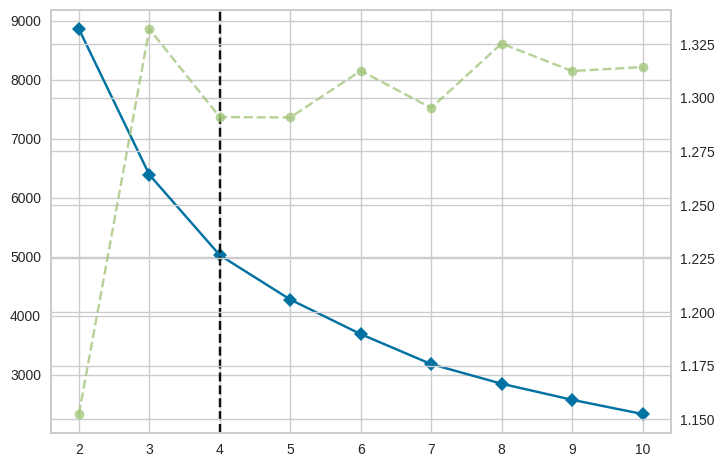

In [14]:
# Now we want to divide customers into cluster based on CLV and predicted NO. purchases and average predicted purchase value

# Firstly, We will see what is the best number for clustering customers into using KElbow method 
kmeans_visulaiser = KElbowVisualizer(KMeans(), k=10)
kmeans_visulaiser.fit(scaled_data)

optimal_clusters = kmeans_visulaiser.elbow_value_

In [15]:
# Secondly, We will divide the customers into clusters based on optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters)
rfm_customers['clusters'] = kmeans.fit_predict(scaled_data)

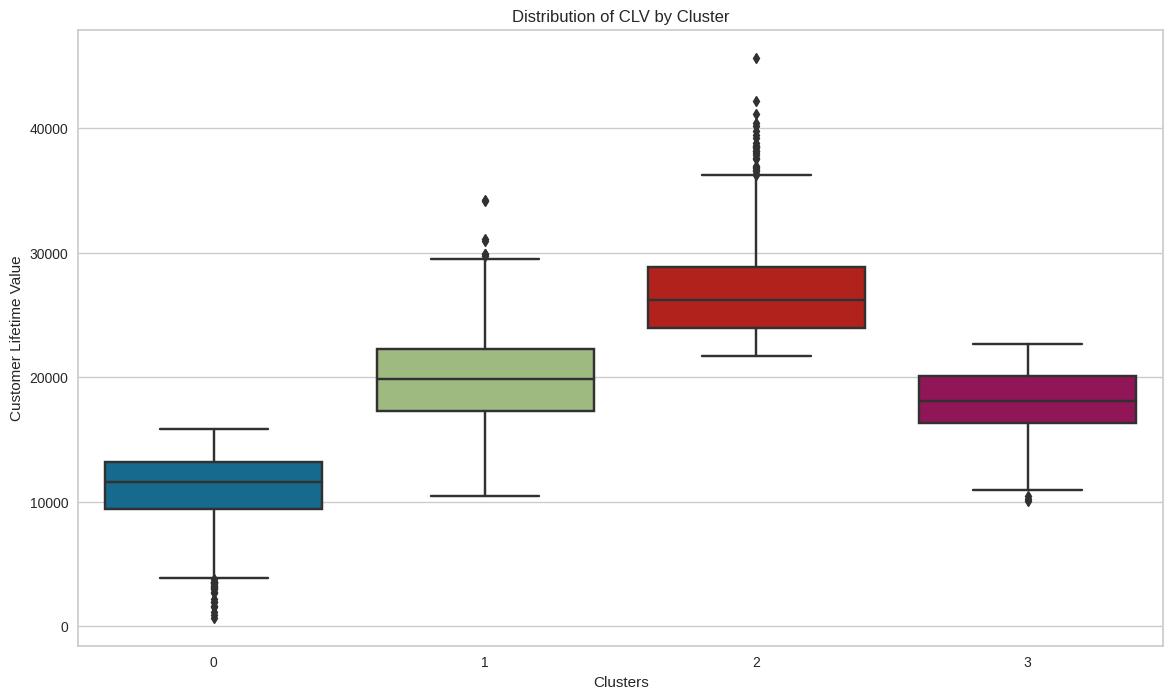

In [16]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='clusters', y='CLV', data=rfm_customers)
plt.title('Distribution of CLV by Cluster')
plt.xlabel('Clusters')
plt.ylabel('Customer Lifetime Value')
plt.show()